# Data loading

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive

import warnings

import heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW

import plotly.express as px

In [ ]:
warnings.filterwarnings('ignore') 
sns.set_theme()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/nlp/dataset/train.tsv', sep='\t')
train_augmented = pd.concat([train, pd.read_csv('/content/drive/MyDrive/nlp/dataset/train_augmented.tsv', sep='\t')], ignore_index=True)
test = pd.read_csv('/content/drive/MyDrive/nlp/dataset/test.tsv', sep='\t')
validation = pd.read_csv('/content/drive/MyDrive/nlp/dataset/valid.tsv', sep='\t')

In [ ]:
train.sample(n=10)

,tweet_no,tweet_text,q1_label,q2_label,q3_label,q4_label,q5_label,q6_label,q7_label,language,tweet_link,tweet_link_count,preprocessed_tweet_text,emojis,translated_emojis,tweet_link_domain,tweet_link_path
1676,808,BFSA closes 5 establishments violating COVID m...,yes,no,yes,no,no,no,no,bg,['https://www.monitor.bg/bg/a/view/babh-zatvor...,1,BFSA closes 5 establishments violating COVID m...,NaN,NaN,monitor,view babh zatvori zavedenija narushiteli covid...
2864,1996,"Nearly 40,000 people infected with COVID-19 ar...",yes,no,yes,no,yes,yes,no,bg,['https://bgnes.bg?????-40-???-????????-?-covi...,1,"Nearly 40,000 people infected with COVID-19 ar...",NaN,NaN,bgnes,NaN
1718,850,"257 cured in the last 24 hours, 169 new cases ...",yes,no,yes,no,no,no,no,bg,['https://bgnes.bg'],1,"257 cured in the last 24 hours, 169 new cases ...",NaN,NaN,bgnes,NaN
5537,1689,They will try our #Corona vaccine in Saudi Ara...,no,NaN,NaN,NaN,NaN,no,yes,ar,['https://twitter.com/just_m_g/status/12922088...,1,They will try our #Corona vaccine in Saudi Ara...,NaN,NaN,twitter,just status photo
5547,1699,#International 50 million doses.. an agreement...,yes,no,yes,no,no,no,yes,ar,['https://www.instagram.com/accounts/login/'],1,#International 50 million doses.. an agreement...,NaN,NaN,instagram,accounts login
541,595,"I’m grateful for new commitments from the EU, ...",no,NaN,NaN,NaN,NaN,no,no,en,[],0,"I’m grateful for new commitments from the EU, ...",NaN,NaN,NaN,NaN
1610,742,18 people from the home in Dzhurkovo infected ...,yes,no,yes,no,no,no,no,bg,['https://dcnews.bg/18-dushi-ot-doma-v-dzhurko...,1,18 people from the home in Dzhurkovo infected ...,NaN,NaN,dcnews,dushi doma dzhurkov zarazeni covid
5237,1389,#Urgent #Russia announces the registration of ...,yes,no,yes,no,yes,no,yes,ar,"['https://www.alyaum.com/a/6270609', 'https://...",2,#Urgent #Russia announces the registration of ...,NaN,NaN,alyaum twitter,alyaum status photo
3327,2459,"90% of those who died in Italy died from, not ...",yes,no,yes,no,no,yes,yes,bg,['https://novavest.bg/2020/07/17/90-o%d1%82-%d...,1,"90% of those who died in Italy died from, not ...",NaN,NaN,novavest,NaN
4523,675,📌#Health officially announces the implementati...,yes,no,yes,no,yes,no,yes,ar,['https://twitter.com/ENAD_Alotaibi/status/129...,1,:pushpin: #Health officially announces the im...,📌📌📌,:pushpin: :pushpin: :pushpin:,twitter,Alotaibi status photo


# Naive Bayes

In [ ]:
def get_best_model_for_different_alpha_values(x_fit, y_fit, x_pred, y_pred):
  alpha_values = []
  accuracy_for_alpha_values = []

  best_model = None
  best_alpha = None
  best_accuracy = 0

  for alpha in np.linspace(0, 3, 31):
    nb = MultinomialNB(alpha=alpha)
    nb.fit(x_fit, y_fit)

    pred = nb.predict(x_pred)

    accuracy = metrics.accuracy_score(y_pred, pred)

    alpha_values.append(alpha)
    accuracy_for_alpha_values.append(accuracy)

    if accuracy > best_accuracy:
      best_model = nb
      best_accuracy = accuracy
      best_alpha = alpha

  fig = px.line(x=alpha_values, y=accuracy_for_alpha_values, title='Accuracy for different alpha values', labels={"x": "Alpha", "y": "Accuracy"})
  fig.show()

  return best_model

def print_metrics(model, x, y):
  pred = model.predict(x)
  print(classification_report(y, pred))

  metrics.ConfusionMatrixDisplay.from_estimator(model, x, y)
  plt.show()

def print_question_distribution(data, label):
  print(data[label].value_counts(), end="\n\n")
  print(data[label].value_counts(normalize = True))

  sns.histplot(data=data, x=label)
  plt.show()

# Question 1
**Verifiable Factual Claim**: Does the tweet contain a verifiable factual claim?


A verifiable factual claim is a sentence claiming that something is true, and this can be verified using factual, verifiable information such as statistics, specific examples, or personal testimony.

In [ ]:
vectorizer = TfidfVectorizer()
le = LabelEncoder()

In [ ]:
x_train_augmented = vectorizer.fit_transform(train_augmented.preprocessed_tweet_text.values)
x_valid = vectorizer.transform(validation.preprocessed_tweet_text.values)
x_test = vectorizer.transform(test.preprocessed_tweet_text.values)

In [ ]:
q1_y_train_augmented = le.fit_transform(train_augmented.q1_label.values)
q1_y_train = le.fit_transform(train.q1_label.values)
q1_y_valid = le.transform(validation.q1_label.values)
q1_y_test = le.transform(test.q1_label.values)

In [ ]:
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'no': 0, 'yes': 1}


Training data distribution 

yes    39852
no     17793
Name: q1_label, dtype: int64

yes    0.691335
no     0.308665
Name: q1_label, dtype: float64


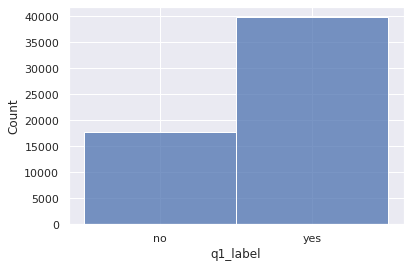

Train data results: 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     17793
           1       0.99      1.00      0.99     39852

    accuracy                           0.99     57645
   macro avg       0.99      0.98      0.98     57645
weighted avg       0.99      0.99      0.99     57645



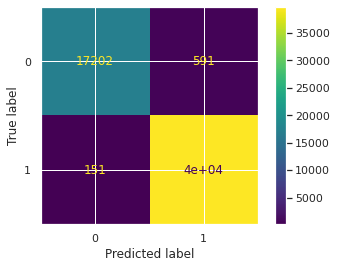

Validation data distribution 

yes    4428
no     1977
Name: q1_label, dtype: int64

yes    0.691335
no     0.308665
Name: q1_label, dtype: float64


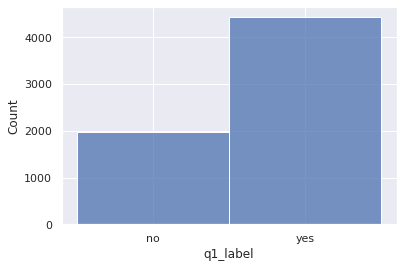

Validation data results:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1977
           1       0.99      1.00      0.99      4428

    accuracy                           0.99      6405
   macro avg       0.99      0.98      0.98      6405
weighted avg       0.99      0.99      0.99      6405



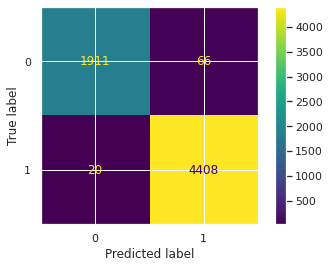

Test data distribution 

yes    947
no     828
Name: q1_label, dtype: int64

yes    0.533521
no     0.466479
Name: q1_label, dtype: float64


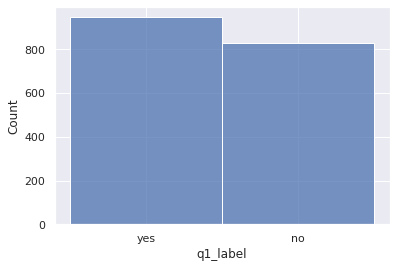

Test data results: 

              precision    recall  f1-score   support

           0       0.74      0.45      0.56       828
           1       0.64      0.86      0.73       947

    accuracy                           0.67      1775
   macro avg       0.69      0.65      0.65      1775
weighted avg       0.69      0.67      0.65      1775



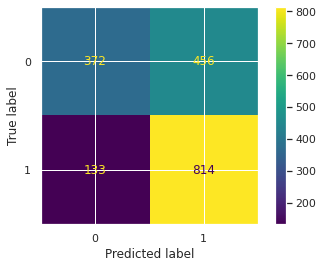

In [ ]:
model = get_best_model_for_different_alpha_values(x_train_augmented, q1_y_train_augmented, x_valid, q1_y_valid)

print("Training data distribution \n")
print_question_distribution(train_augmented, "q1_label")

print("Train data results: \n")
print_metrics(model, x_train_augmented, q1_y_train_augmented)

print("Validation data distribution \n")
print_question_distribution(validation, "q1_label")

print("Validation data results:\n")
print_metrics(model, x_valid, q1_y_valid)

print("Test data distribution \n")
print_question_distribution(test, "q1_label")

print("Test data results: \n")
print_metrics(model, x_test, q1_y_test)

Test data results: 

              precision    recall  f1-score   support

           0       0.81      0.44      0.57       828
           1       0.65      0.91      0.76       947

    accuracy                           0.69      1775
   macro avg       0.73      0.68      0.67      1775
weighted avg       0.72      0.69      0.67      1775



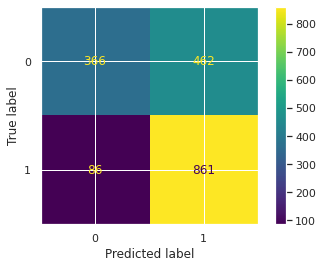

In [ ]:
model = get_best_model_for_different_alpha_values(x_train_augmented, q1_y_train_augmented, x_test, q1_y_test)

print("Test data results: \n")
print_metrics(model, x_test, q1_y_test)

In [ ]:
vectorizer = TfidfVectorizer()
le = LabelEncoder()

x_train = vectorizer.fit_transform(train.preprocessed_tweet_text.values)
x_valid = vectorizer.transform(validation.preprocessed_tweet_text.values)
x_test = vectorizer.transform(test.preprocessed_tweet_text.values)

q1_y_train = le.fit_transform(train.q1_label.values)
q1_y_valid = le.transform(validation.q1_label.values)
q1_y_test = le.transform(test.q1_label.values)

Training data distribution
yes    4428
no     1977
Name: q1_label, dtype: int64

yes    0.691335
no     0.308665
Name: q1_label, dtype: float64


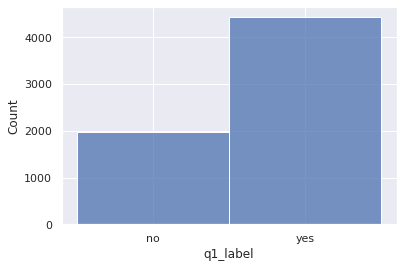

Train data results: 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1977
           1       0.99      1.00      0.99      4428

    accuracy                           0.99      6405
   macro avg       0.99      0.99      0.99      6405
weighted avg       0.99      0.99      0.99      6405



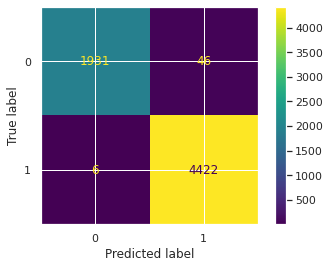

Validation data results:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1977
           1       0.99      1.00      0.99      4428

    accuracy                           0.99      6405
   macro avg       0.99      0.99      0.99      6405
weighted avg       0.99      0.99      0.99      6405



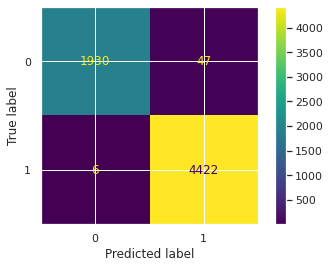

Test data results: 

              precision    recall  f1-score   support

           0       0.75      0.47      0.58       828
           1       0.65      0.87      0.74       947

    accuracy                           0.68      1775
   macro avg       0.70      0.67      0.66      1775
weighted avg       0.70      0.68      0.67      1775



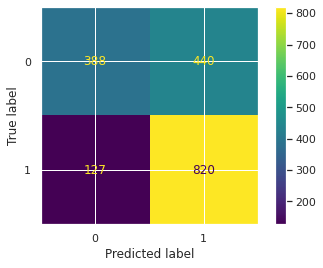

In [ ]:
model = get_best_model_for_different_alpha_values(x_train, q1_y_train, x_valid, q1_y_valid)

print("Training data distribution")
print_question_distribution(train, "q1_label")

print("Train data results: \n")
print_metrics(model, x_train, q1_y_train)

print("Validation data results:\n")
print_metrics(model, x_valid, q1_y_valid)

print("Test data results: \n")
print_metrics(model, x_test, q1_y_test)

# Questions 2, 3, 4

## Question 2
**False Information**: To what extent does the tweet appear to contain false information?


The stated claim may contain false information. This question labels the tweets with the categories mentioned below. False Information appears on social media platforms, blogs, and news-articles to deliberately misinform or deceive the readers.

## Question 3

**Interest to General Public**: Will the tweet have an effect on or be of interest to the general public?


Most often people do not make interesting claims, which can be verified by our general knowledge. For example, "Sky is blue'' is a claim, however, it is not interesting to the general public. In general, topics such as healthcare, political news and findings, and current events are of higher interest to the general public. Using the five point Likert scale the labels are defined below.

## Question 4

**Harmfulness**: To what extent is the tweet harmful to the society/person(s)/company(s)/product(s)?


The purpose of this question is to determine if the content of the tweet aims to and can negatively affect the society as a whole, specific person(s), company(s), product(s) or spread rumors about them. The content intends to harm or weaponize the information. A rumor involves a form of a statement whose veracity is not quickly or ever confirmed.

Question 2 



Training data distribution
no     35118
yes     4311
Name: q2_label, dtype: int64

no     0.890664
yes    0.109336
Name: q2_label, dtype: float64


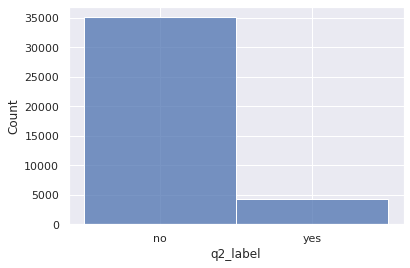

Train data results: 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     35118
           1       1.00      0.95      0.97      4311

    accuracy                           0.99     39429
   macro avg       1.00      0.98      0.99     39429
weighted avg       0.99      0.99      0.99     39429



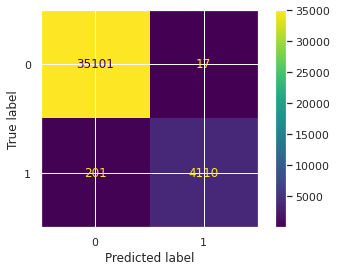

Validation data distribution
no     3902
yes     479
Name: q2_label, dtype: int64

no     0.890664
yes    0.109336
Name: q2_label, dtype: float64


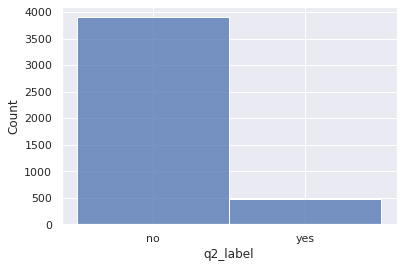

Validation data results:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3902
           1       0.99      0.96      0.97       479

    accuracy                           0.99      4381
   macro avg       0.99      0.98      0.98      4381
weighted avg       0.99      0.99      0.99      4381



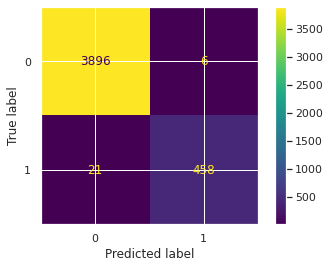

Test data distribution
no     862
yes     71
Name: q2_label, dtype: int64

no     0.923901
yes    0.076099
Name: q2_label, dtype: float64


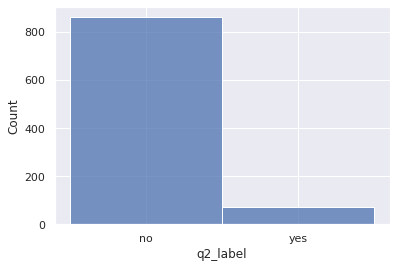

Test data results: 

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       862
           1       0.25      0.10      0.14        71

    accuracy                           0.91       933
   macro avg       0.59      0.54      0.55       933
weighted avg       0.88      0.91      0.89       933



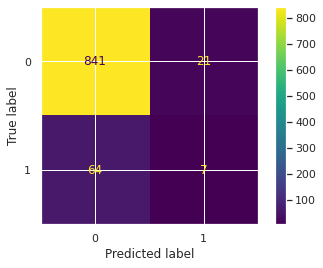



-----------------------------------------------------------------


Question 3 



Training data distribution
yes    38835
no      1152
Name: q3_label, dtype: int64

yes    0.971191
no     0.028809
Name: q3_label, dtype: float64


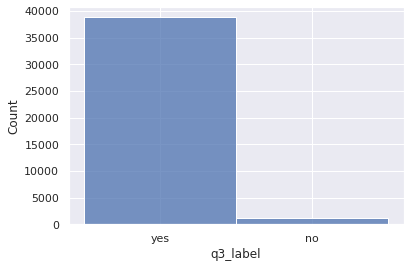

Train data results: 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1152
           1       1.00      1.00      1.00     38835

    accuracy                           1.00     39987
   macro avg       1.00      0.99      0.99     39987
weighted avg       1.00      1.00      1.00     39987



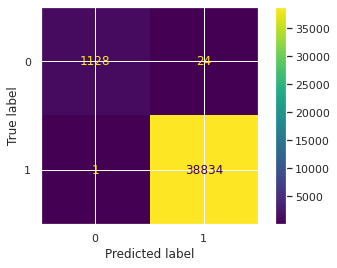

Validation data distribution
yes    4315
no      128
Name: q3_label, dtype: int64

yes    0.971191
no     0.028809
Name: q3_label, dtype: float64


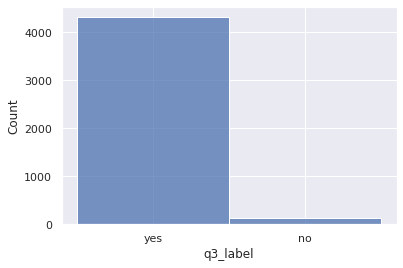

Validation data results:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       128
           1       1.00      1.00      1.00      4315

    accuracy                           1.00      4443
   macro avg       1.00      0.99      1.00      4443
weighted avg       1.00      1.00      1.00      4443



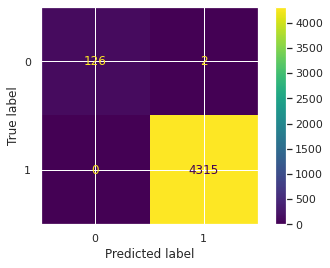

Test data distribution
yes    944
no       7
Name: q3_label, dtype: int64

yes    0.992639
no     0.007361
Name: q3_label, dtype: float64


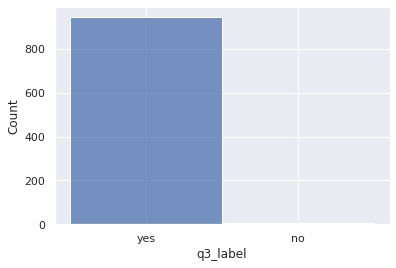

Test data results: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.99      1.00      1.00       944

    accuracy                           0.99       951
   macro avg       0.50      0.50      0.50       951
weighted avg       0.99      0.99      0.99       951



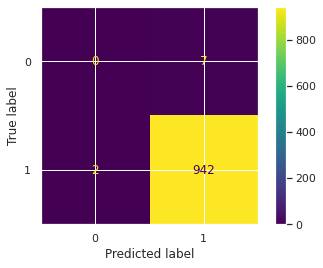



-----------------------------------------------------------------


Question 4 



Training data distribution
no     33705
yes     6192
Name: q4_label, dtype: int64

no     0.8448
yes    0.1552
Name: q4_label, dtype: float64


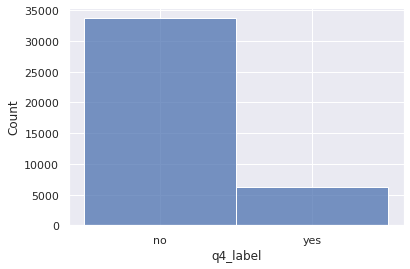

Train data results: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33705
           1       0.99      0.98      0.99      6192

    accuracy                           1.00     39897
   macro avg       1.00      0.99      0.99     39897
weighted avg       1.00      1.00      1.00     39897



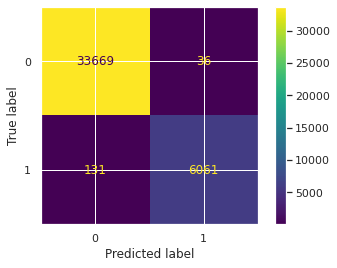

Validation data distribution
no     3745
yes     688
Name: q4_label, dtype: int64

no     0.8448
yes    0.1552
Name: q4_label, dtype: float64


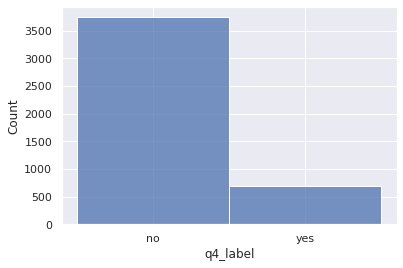

Validation data results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3745
           1       0.99      0.99      0.99       688

    accuracy                           1.00      4433
   macro avg       0.99      0.99      0.99      4433
weighted avg       1.00      1.00      1.00      4433



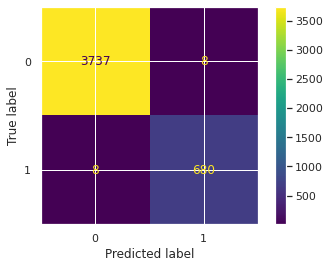

Test data distribution
no     820
yes    128
Name: q4_label, dtype: int64

no     0.864979
yes    0.135021
Name: q4_label, dtype: float64


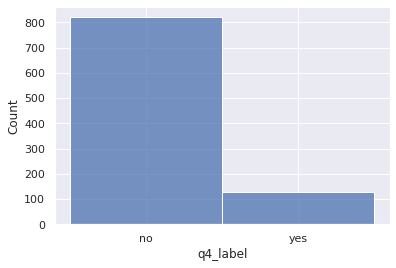

Test data results: 

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       820
           1       0.46      0.21      0.29       128

    accuracy                           0.86       948
   macro avg       0.67      0.59      0.61       948
weighted avg       0.83      0.86      0.84       948



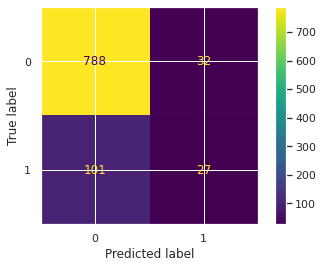



-----------------------------------------------------------------




In [ ]:
for question_idx in [2, 3, 4]:
  print(f"Question {question_idx} \n")

  vectorizer = TfidfVectorizer()

  x_train_augmented = vectorizer.fit_transform(train_augmented[train_augmented[f"q{question_idx}_label"].isin(["yes", "no"])].preprocessed_tweet_text.values)
  x_valid = vectorizer.transform(validation[validation[f"q{question_idx}_label"].isin(["yes", "no"])].preprocessed_tweet_text.values)
  x_test = vectorizer.transform(test[test[f"q{question_idx}_label"].isin(["yes", "no"])].preprocessed_tweet_text.values)

  le = LabelEncoder()

  qi_y_train_augmented = le.fit_transform(train_augmented[train_augmented[f"q{question_idx}_label"].isin(["yes", "no"])][f"q{question_idx}_label"].values)
  qi_y_valid = le.transform(validation[validation[f"q{question_idx}_label"].isin(["yes", "no"])][f"q{question_idx}_label"].values)
  qi_y_test = le.transform(test[test[f"q{question_idx}_label"].isin(["yes", "no"])][f"q{question_idx}_label"].values)

  model = get_best_model_for_different_alpha_values(x_train_augmented, qi_y_train_augmented, x_valid, qi_y_valid)

  print("Training data distribution")
  print_question_distribution(train_augmented[train_augmented[f"q{question_idx}_label"].isin(["yes", "no"])], f"q{question_idx}_label")

  print("Train data results: \n")
  print_metrics(model, x_train_augmented, qi_y_train_augmented)

  print("Validation data distribution")
  print_question_distribution(validation[validation[f"q{question_idx}_label"].isin(["yes", "no"])], f"q{question_idx}_label")

  print("Validation data results:\n")
  print_metrics(model, x_valid, qi_y_valid)

  print("Test data distribution")
  print_question_distribution(test[test[f"q{question_idx}_label"].isin(["yes", "no"])], f"q{question_idx}_label")

  print("Test data results: \n")
  print_metrics(model, x_test, qi_y_test)

  print("\n\n-----------------------------------------------------------------\n\n")

# Transfer learning BERT

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/nlp/dataset/train.tsv', sep='\t')
train_augmented = pd.concat([train, pd.read_csv('/content/drive/MyDrive/nlp/dataset/train_augmented.tsv', sep='\t')], ignore_index=True)
test = pd.read_csv('/content/drive/MyDrive/nlp/dataset/test.tsv', sep='\t')
valid = pd.read_csv('/content/drive/MyDrive/nlp/dataset/valid.tsv', sep='\t')

In [ ]:
device = torch.device("cuda")

The **BERT base uncased** model was pretrained on BookCorpus (https://yknzhu.wixsite.com/mbweb), a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers).



In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of tweets: 6405
Average tweet length: 31.96471506635441
Max tweet length: 1605
Top 30 largest tweets: [1605, 832, 353, 220, 87, 85, 84, 83, 83, 83, 83, 82, 81, 80, 80, 79, 79, 79, 79, 79, 78, 78, 78, 78, 78, 77, 77, 77, 77, 76]


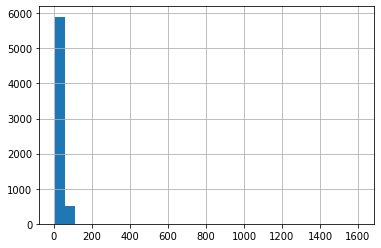

In [ ]:
tweets_length = [len(tweet.split()) for tweet in train.preprocessed_tweet_text.values]

pd.Series(tweets_length).hist(bins = 30)

print(f"Number of tweets: {len(tweets_length)}")
print(f"Average tweet length: {sum(tweets_length) / len(tweets_length)}")
print(f"Max tweet length: {max(tweets_length)}")
print(f"Top 30 largest tweets: {heapq.nlargest(30, tweets_length)}")

In [ ]:
train_tokens = tokenizer.batch_encode_plus(
    train.preprocessed_tweet_text.values.tolist(),
    max_length=100,
    padding='max_length',
    truncation=True
)

valid_tokens = tokenizer.batch_encode_plus(
    valid.preprocessed_tweet_text.values.tolist(),
    max_length=100,
    padding='max_length',
    truncation=True
)

test_tokens = tokenizer.batch_encode_plus(
    test.preprocessed_tweet_text.values.tolist(),
    max_length=100,
    padding='max_length',
    truncation=True
)

In [ ]:
le = LabelEncoder()
le.fit(train.q1_label.values)

train_input_ids = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(le.transform(train.q1_label.values))

valid_input_ids = torch.tensor(valid_tokens['input_ids'])
valid_mask = torch.tensor(valid_tokens['attention_mask'])
valid_y = torch.tensor(le.transform(valid.q1_label.values))

In [ ]:
BATCH_SIZE = 32

train_tensor_dataset = TensorDataset(train_input_ids, train_mask, train_y)
train_sampler = RandomSampler(train_tensor_dataset)
train_data_loader = DataLoader(train_tensor_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_tensor_dataset = TensorDataset(valid_input_ids, valid_mask, valid_y)
valid_sampler = SequentialSampler(valid_tensor_dataset)
valid_data_loader = DataLoader(valid_tensor_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class PretrainedBertWithExtraLayers(nn.Module):
    def __init__(self, bert):
      super().__init__()

      self._bert = bert
      
      self._linear1 = nn.Linear(768, 512)
      self._relu =  nn.ReLU()
      self._dropout = nn.Dropout(0.1)
      self._linear2 = nn.Linear(512, 2)
      self._softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, mask):
      _, x = self._bert(input_ids, attention_mask=mask, return_dict=False)
      
      x = self._linear1(x)
      x = self._relu(x)
      x = self._dropout(x)
      x = self._linear2(x)      
      x = self._softmax(x)

      return x

In [ ]:
model = PretrainedBertWithExtraLayers(bert)
model = model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr = 1e-3)

weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_y.numpy()), y=train_y.numpy())
weights = torch.tensor(weights, dtype=torch.float)
weights = weights.to(device)

cross_entropy  = nn.NLLLoss(weight=weights)

In [ ]:
def train():
  model.train()
  total_loss = 0
  
  all_preds = []
  
  for step, batch in enumerate(train_data_loader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_data_loader)))

    batch = [r.to(device) for r in batch]
    input_ids, mask, labels = batch

    model.zero_grad()        
    preds = model(input_ids, mask)

    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()

    loss.backward()

    # Helps with preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    preds = preds.detach().cpu().numpy()
    all_preds.append(preds)

  avg_loss = total_loss / len(train_data_loader)
  all_preds = np.concatenate(all_preds, axis=0)

  return avg_loss, all_preds

In [ ]:
def evaluate():  
  print("\nEvaluating model ...")
  
  model.eval()
  total_loss = 0
  
  all_preds = []

  for step, batch in enumerate(valid_data_loader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valid_data_loader)))

    batch = [t.to(device) for t in batch]
    input_ids, mask, labels = batch

    with torch.no_grad():
      preds = model(input_ids, mask)

      loss = cross_entropy(preds, labels)
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()
      all_preds.append(preds)

  avg_loss = total_loss / len(valid_data_loader) 
  all_preds = np.concatenate(all_preds, axis=0)

  return avg_loss, all_preds

In [ ]:
EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(EPOCHS):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
    
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_weights.pt')
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch    50  of    201.
  Batch   100  of    201.
  Batch   150  of    201.
  Batch   200  of    201.

Evaluating model ...
  Batch    50  of    201.
  Batch   100  of    201.
  Batch   150  of    201.
  Batch   200  of    201.

Training Loss: 0.544
Validation Loss: 0.554

 Epoch 2 / 50
  Batch    50  of    201.
  Batch   100  of    201.
  Batch   150  of    201.
  Batch   200  of    201.

Evaluating model ...
  Batch    50  of    201.
  Batch   100  of    201.
  Batch   150  of    201.
  Batch   200  of    201.

Training Loss: 0.550
Validation Loss: 0.511

 Epoch 3 / 50
  Batch    50  of    201.
  Batch   100  of    201.
  Batch   150  of    201.
  Batch   200  of    201.

Evaluating model ...
  Batch    50  of    201.
  Batch   100  of    201.
  Batch   150  of    201.
  Batch   200  of    201.

Training Loss: 0.556
Validation Loss: 0.535

 Epoch 4 / 50
  Batch    50  of    201.
  Batch   100  of    201.
  Batch   150  of    201.
  Batch   200  of    201.

Evaluating

KeyboardInterrupt: ignored

In [ ]:
path = '/content/drive/MyDrive/nlp/model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
BATCH_SIZE = 25

test_input_ids = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(le.transform(test.q1_label.values))

test_tensor_dataset = TensorDataset(test_input_ids, test_mask, test_y)
test_sampler = SequentialSampler(test_tensor_dataset)
test_data_loader = DataLoader(test_tensor_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

with torch.no_grad():
  all_preds = None

  for step, batch in enumerate(test_data_loader):
     input_ids, mask, _ = batch

     preds = model(input_ids.to(device), mask.to(device))
     all_preds = np.concatenate([all_preds, preds.detach().cpu().numpy()]) if all_preds is not None else preds.detach().cpu().numpy() 

yes    947
no     828
Name: q1_label, dtype: int64

yes    0.533521
no     0.466479
Name: q1_label, dtype: float64


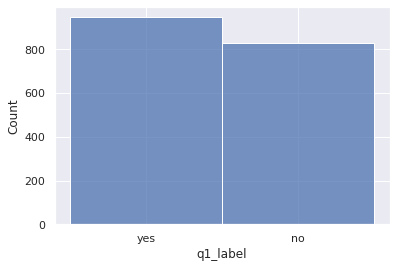

In [ ]:
print_question_distribution(test, "q1_label")

In [ ]:
all_preds = np.argmax(all_preds, axis=1)
print(classification_report(test_y, all_preds))

              precision    recall  f1-score   support

           0       0.80      0.70      0.75       828
           1       0.76      0.85      0.80       947

    accuracy                           0.78      1775
   macro avg       0.78      0.77      0.78      1775
weighted avg       0.78      0.78      0.78      1775



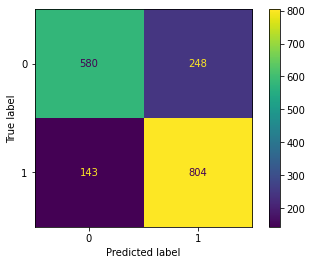

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(test_y, all_preds)
plt.show()